In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print("Library Versions:")
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('tensorflow:',tf.__version__)
print('tensorflow probability:', tfp.__version__)

Library Versions:
numpy: 1.24.3
pandas: 1.5.3
tensorflow: 2.13.0
tensorflow probability: 0.21.0


In [4]:
n_epochs = 200
verbose_option = True

# Classification for Ship Detection


Load Ship Detection Dataset

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ROOT_PATH = "shipsnet"
LR = 1e-3
BATCH_SIZE=3200

def normalize_img(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(ROOT_PATH,
                            labels = 'inferred',
                            label_mode = 'categorical',
                            class_names = None,
                            color_mode = "rgb",
                            batch_size = BATCH_SIZE,
                            image_size = (80, 80),
                            shuffle = True,
                            seed = 42,
                            subset="both",
                            validation_split = 0.2,
)

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Using 800 files for validation.


Using Tensoflow, perform  non-linear binary classification model for the classification dataset.

In [43]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='linear')(h3)

model = keras.Model(inputs=inputs, outputs=p)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)

In [44]:
model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.7263 - categorical_accuracy: 0.2847 - categorical_crossentropy: 0.7263
Epoch 2/200
1/1 [==============================] - 0s 63ms/step - loss: 2.0598 - categorical_accuracy: 0.7572 - categorical_crossentropy: 2.0598
Epoch 3/200
1/1 [==============================] - 0s 63ms/step - loss: 1.1068 - categorical_accuracy: 0.7572 - categorical_crossentropy: 1.1068
Epoch 4/200
1/1 [==============================] - 0s 63ms/step - loss: 0.6486 - categorical_accuracy: 0.7572 - categorical_crossentropy: 0.6486
Epoch 5/200
1/1 [==============================] - 0s 63ms/step - loss: 0.5750 - categorical_accuracy: 0.7572 - categorical_crossentropy: 0.5750
Epoch 6/200
1/1 [==============================] - 0s 63ms/step - loss: 0.5424 - categorical_accuracy: 0.7572 - categorical_crossentropy: 0.5424
Epoch 7/200
1/1 [==============================] - 0s 62ms/step - loss: 0.5386 - categorical_accuracy: 0.7572 - categorical_crossent

1/1 [==============================] - 0s 63ms/step - loss: 0.2274 - categorical_accuracy: 0.9100 - categorical_crossentropy: 0.2274
Epoch 114/200
1/1 [==============================] - 0s 63ms/step - loss: 0.2278 - categorical_accuracy: 0.9078 - categorical_crossentropy: 0.2278
Epoch 115/200
1/1 [==============================] - 0s 63ms/step - loss: 0.2270 - categorical_accuracy: 0.9112 - categorical_crossentropy: 0.2270
Epoch 116/200
1/1 [==============================] - 0s 63ms/step - loss: 0.2253 - categorical_accuracy: 0.9081 - categorical_crossentropy: 0.2253
Epoch 117/200
1/1 [==============================] - 0s 63ms/step - loss: 0.2241 - categorical_accuracy: 0.9097 - categorical_crossentropy: 0.2241
Epoch 118/200
1/1 [==============================] - 0s 62ms/step - loss: 0.2240 - categorical_accuracy: 0.9097 - categorical_crossentropy: 0.2240
Epoch 119/200
1/1 [==============================] - 0s 62ms/step - loss: 0.2241 - categorical_accuracy: 0.9087 - categorical_crosse

Evaluate the classification model on the test data

In [45]:
model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 1s 702ms/step - loss: 0.2271 - categorical_accuracy: 0.9100 - categorical_crossentropy: 0.2271


[0.22709143161773682, 0.9100000262260437, 0.22709143161773682]

In [46]:
examples, labels = list(test_dataset.as_numpy_iterator())[0]

In [47]:
model(np.reshape(examples[5],[1,80,80,3])).numpy()[0,0]

-3.8197834

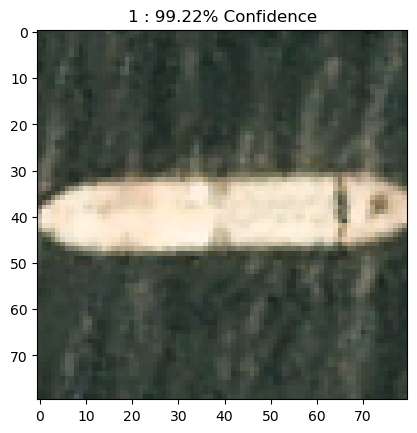

In [48]:
plt.figure()
plt.imshow(examples[5])
confidence = tf.nn.softmax(model(np.reshape(examples[5],[1,80,80,3])).numpy())[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

## Gradient Matching

In [49]:
from art.attacks.poisoning import GradientMatchingAttack

In [50]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(100, activation="relu")(flat)
h2 = layers.Dense(100, activation="relu")(h1)
p = layers.Dense(2,activation='linear')(h2)

bb_model = keras.Model(inputs=inputs, outputs=p)

bb_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.legacy.Adam(LR),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)

In [51]:
from art.estimators.classification import TensorFlowV2Classifier
classifier = TensorFlowV2Classifier(
    model=bb_model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.legacy.Adam(LR),
    nb_classes=2,
    input_shape=(80, 80, 3),
    clip_values=(0, 1),
)
gradmatching = GradientMatchingAttack(classifier=classifier, 
                                      percent_poison=0.3, 
                                      epsilon=0.1, 
                                      max_trials=8, 
                                      max_epochs=250, 
                                      learning_rate_schedule=([0.1, 0.01, 0.001, 0.0001], [100, 150, 200, 220]), 
                                      batch_size=512, 
                                      clip_values=(0, 1.0), 
                                      verbose=1)

In [52]:
train_examples, train_labels = list(train_dataset.as_numpy_iterator())[0]

In [53]:
ship_idx = np.where(train_labels[:,1]==1)


In [54]:
print(ship_idx[0].shape)

(777,)


In [55]:
opp_labels = []
opp_x = []
# trigger to misclassify 1 examples as 0 (ship as not ship)
for index in ship_idx[0]:
    opp_labels.append(train_labels[index])
    opp_x.append(1-train_examples[index])

ol_np = np.array(opp_labels)
ox_np = np.array(opp_x)

print(ol_np.shape)
print(ox_np.shape)

(777, 2)
(777, 80, 80, 3)


In [56]:
adv_ex = gradmatching.poison(x_trigger=ox_np,
                             y_trigger=ol_np,
                             x_train=train_examples,
                             y_train=train_labels)

  0%|          | 0/8 [00:00<?, ?it/s]

The following Variables were used a Lambda layer's call (lambda_33), but
are not present in its tracked objects:
  <tf.Variable 'dense_15/kernel:0' shape=(19200, 100) dtype=float32>
  <tf.Variable 'dense_15/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_16/kernel:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'dense_16/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_17/kernel:0' shape=(100, 2) dtype=float32>
  <tf.Variable 'dense_17/bias:0' shape=(2,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 0s 9ms/step
The following Variables were used a Lambda layer's call (lambda_35), but
are not present in its tracked objects:
  <tf.Variable 'dense_15/kernel:0' shape=(19200, 100) dtype=float32>
  <tf.Variable 'dense_15/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_16/kernel:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'dense_16/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_17/kernel:0' shape=(100, 2) dtype=float32>
  <tf.Variable 'dense_17/bias:0' shape=(2,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 0s 9ms/step
The following Variables were used a Lambda layer's call (lambda_37), but
are not present in its tracked objects:
  <tf.Variable 'dense_15/kernel:0' shape=(19200, 100) dtype=float32>
  <tf.Variable 'dense_15/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_16/kernel:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'dense_16/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_17/kernel:0' shape=(100, 2) dtype=float32>
  <tf.Variable 'dense_17/bias:0' shape=(2,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 0s 9ms/step
The following Variables were used a Lambda layer's call (lambda_39), but
are not present in its tracked objects:
  <tf.Variable 'dense_15/kernel:0' shape=(19200, 100) dtype=float32>
  <tf.Variable 'dense_15/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_16/kernel:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'dense_16/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_17/kernel:0' shape=(100, 2) dtype=float32>
  <tf.Variable 'dense_17/bias:0' shape=(2,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 0s 9ms/step
The following Variables were used a Lambda layer's call (lambda_41), but
are not present in its tracked objects:
  <tf.Variable 'dense_15/kernel:0' shape=(19200, 100) dtype=float32>
  <tf.Variable 'dense_15/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_16/kernel:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'dense_16/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_17/kernel:0' shape=(100, 2) dtype=float32>
  <tf.Variable 'dense_17/bias:0' shape=(2,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 0s 9ms/step
The following Variables were used a Lambda layer's call (lambda_43), but
are not present in its tracked objects:
  <tf.Variable 'dense_15/kernel:0' shape=(19200, 100) dtype=float32>
  <tf.Variable 'dense_15/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_16/kernel:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'dense_16/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_17/kernel:0' shape=(100, 2) dtype=float32>
  <tf.Variable 'dense_17/bias:0' shape=(2,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 0s 9ms/step
The following Variables were used a Lambda layer's call (lambda_45), but
are not present in its tracked objects:
  <tf.Variable 'dense_15/kernel:0' shape=(19200, 100) dtype=float32>
  <tf.Variable 'dense_15/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_16/kernel:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'dense_16/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_17/kernel:0' shape=(100, 2) dtype=float32>
  <tf.Variable 'dense_17/bias:0' shape=(2,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 0s 9ms/step
The following Variables were used a Lambda layer's call (lambda_47), but
are not present in its tracked objects:
  <tf.Variable 'dense_15/kernel:0' shape=(19200, 100) dtype=float32>
  <tf.Variable 'dense_15/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_16/kernel:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'dense_16/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'dense_17/kernel:0' shape=(100, 2) dtype=float32>
  <tf.Variable 'dense_17/bias:0' shape=(2,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


0epoch [00:00, ?epoch/s]

2/2 [==============================] - 0s 9ms/step
Best B-score: 0.24771735


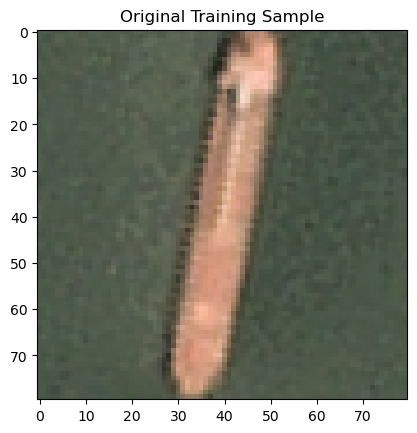

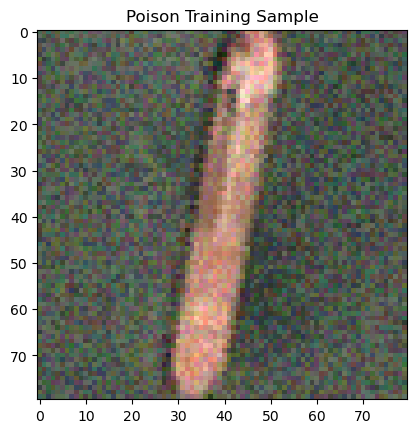

In [57]:
plt.figure()
adv_example = train_examples[4]
plt.imshow(np.clip(adv_example,0,255))
plt.title('Original Training Sample')
plt.show()

plt.figure()
adv_example = adv_ex[0][4]
plt.imshow(np.clip(adv_example,0,255))
plt.title('Poison Training Sample')
plt.show()

In [58]:
model.fit(adv_ex[0], adv_ex[1], epochs=n_epochs, verbose=True)

Epoch 1/200
100/100 [==============================] - 0s 4ms/step - loss: 0.5080 - categorical_accuracy: 0.8544 - categorical_crossentropy: 0.5080
Epoch 2/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1372 - categorical_accuracy: 0.9563 - categorical_crossentropy: 0.1372
Epoch 3/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0933 - categorical_accuracy: 0.9728 - categorical_crossentropy: 0.0933
Epoch 4/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0959 - categorical_accuracy: 0.9706 - categorical_crossentropy: 0.0959
Epoch 5/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0981 - categorical_accuracy: 0.9716 - categorical_crossentropy: 0.0981
Epoch 6/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1142 - categorical_accuracy: 0.9647 - categorical_crossentropy: 0.1142
Epoch 7/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0512 - categorical_accuracy: 0.9859

100/100 [==============================] - 0s 4ms/step - loss: 0.0093 - categorical_accuracy: 0.9975 - categorical_crossentropy: 0.0093
Epoch 57/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0055 - categorical_accuracy: 0.9994 - categorical_crossentropy: 0.0055
Epoch 58/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0085 - categorical_accuracy: 0.9975 - categorical_crossentropy: 0.0085
Epoch 59/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0092 - categorical_accuracy: 0.9978 - categorical_crossentropy: 0.0092
Epoch 60/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - categorical_crossentropy: 0.0016
Epoch 61/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0224 - categorical_accuracy: 0.9950 - categorical_crossentropy: 0.0224
Epoch 62/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0716 - categorical_accuracy: 0.9847 - cat

100/100 [==============================] - 0s 4ms/step - loss: 7.7479e-06 - categorical_accuracy: 1.0000 - categorical_crossentropy: 7.7479e-06
Epoch 162/200
100/100 [==============================] - 0s 4ms/step - loss: 7.2715e-06 - categorical_accuracy: 1.0000 - categorical_crossentropy: 7.2715e-06
Epoch 163/200
100/100 [==============================] - 0s 4ms/step - loss: 6.9795e-06 - categorical_accuracy: 1.0000 - categorical_crossentropy: 6.9795e-06
Epoch 164/200
100/100 [==============================] - 0s 4ms/step - loss: 6.6193e-06 - categorical_accuracy: 1.0000 - categorical_crossentropy: 6.6193e-06
Epoch 165/200
100/100 [==============================] - 0s 4ms/step - loss: 6.2349e-06 - categorical_accuracy: 1.0000 - categorical_crossentropy: 6.2349e-06
Epoch 166/200
100/100 [==============================] - 0s 4ms/step - loss: 5.7657e-06 - categorical_accuracy: 1.0000 - categorical_crossentropy: 5.7657e-06
Epoch 167/200
100/100 [==============================] - 0s 4ms/st

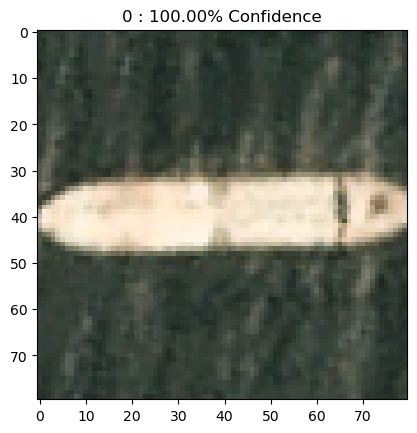

In [59]:
plt.figure()
plt.imshow(examples[5])
confidence = tf.nn.softmax(model(np.reshape(examples[5],[1,80,80,3])).numpy())[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [60]:
model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 0s 33ms/step - loss: 3.4823 - categorical_accuracy: 0.7437 - categorical_crossentropy: 3.4823


[3.482257127761841, 0.7437499761581421, 3.482257127761841]

# Differential Privacy

In [61]:
import tensorflow_privacy as tfpv

In [82]:
batch_size = BATCH_SIZE
l2_norm_clip = 1.0
noise_multiplier = 0.5
num_microbatches = 1
learning_rate = LR

In [83]:
if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [84]:
# Select your differentially private optimizer
dp_optimizer = tfpv.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

In [85]:
inputs = layers.Input(shape=(80,80,3))
flat = layers.Flatten()(inputs)
h1 = layers.Dense(50, activation="relu")(flat)
h2 = layers.Dense(50, activation="relu")(h1)
h3 = layers.Dense(50, activation="relu")(h2)
p = layers.Dense(2,activation='linear')(h3)

dp_model = keras.Model(inputs=inputs, outputs=p)

dp_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=dp_optimizer,
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)

In [86]:
dp_model.fit(train_dataset, epochs=n_epochs, verbose=True)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.6476 - categorical_accuracy: 0.7709 - categorical_crossentropy: 0.6476
Epoch 2/200
1/1 [==============================] - 0s 63ms/step - loss: 0.6517 - categorical_accuracy: 0.7741 - categorical_crossentropy: 0.6517
Epoch 3/200
1/1 [==============================] - 0s 63ms/step - loss: 0.6443 - categorical_accuracy: 0.7741 - categorical_crossentropy: 0.6443
Epoch 4/200
1/1 [==============================] - 0s 63ms/step - loss: 0.6383 - categorical_accuracy: 0.7744 - categorical_crossentropy: 0.6383
Epoch 5/200
1/1 [==============================] - 0s 63ms/step - loss: 0.6317 - categorical_accuracy: 0.7759 - categorical_crossentropy: 0.6317
Epoch 6/200
1/1 [==============================] - 0s 63ms/step - loss: 0.6253 - categorical_accuracy: 0.7766 - categorical_crossentropy: 0.6253
Epoch 7/200
1/1 [==============================] - 0s 63ms/step - loss: 0.6192 - categorical_accuracy: 0.7750 - categorical_crossent

1/1 [==============================] - 0s 63ms/step - loss: 0.3972 - categorical_accuracy: 0.8406 - categorical_crossentropy: 0.3972
Epoch 114/200
1/1 [==============================] - 0s 63ms/step - loss: 0.3958 - categorical_accuracy: 0.8403 - categorical_crossentropy: 0.3958
Epoch 115/200
1/1 [==============================] - 0s 63ms/step - loss: 0.3945 - categorical_accuracy: 0.8406 - categorical_crossentropy: 0.3945
Epoch 116/200
1/1 [==============================] - 0s 63ms/step - loss: 0.3934 - categorical_accuracy: 0.8403 - categorical_crossentropy: 0.3934
Epoch 117/200
1/1 [==============================] - 0s 63ms/step - loss: 0.3924 - categorical_accuracy: 0.8397 - categorical_crossentropy: 0.3924
Epoch 118/200
1/1 [==============================] - 0s 63ms/step - loss: 0.3913 - categorical_accuracy: 0.8397 - categorical_crossentropy: 0.3913
Epoch 119/200
1/1 [==============================] - 0s 63ms/step - loss: 0.3900 - categorical_accuracy: 0.8413 - categorical_crosse

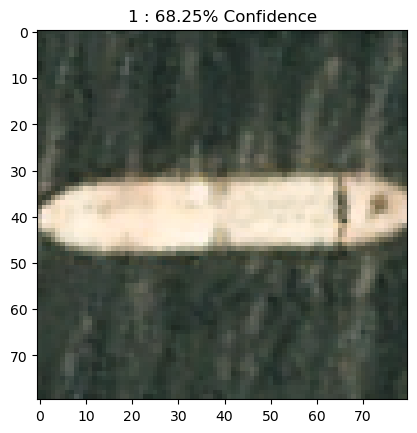

In [87]:
plt.figure()
plt.imshow(examples[5])
confidence = tf.nn.softmax(dp_model(np.reshape(examples[5],[1,80,80,3])).numpy())[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [88]:
dp_model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 0s 195ms/step - loss: 0.3456 - categorical_accuracy: 0.8500 - categorical_crossentropy: 0.3456


[0.3456059396266937, 0.8500000238418579, 0.3456059396266937]

## Attack Differential Privacy model with poisoned dataset

In [89]:
dp_model.fit(adv_ex[0], adv_ex[1], epochs=n_epochs, verbose=True)

Epoch 1/200
100/100 [==============================] - 0s 5ms/step - loss: 0.4672 - categorical_accuracy: 0.8094 - categorical_crossentropy: 0.4672
Epoch 2/200
100/100 [==============================] - 0s 5ms/step - loss: 0.4142 - categorical_accuracy: 0.8303 - categorical_crossentropy: 0.4142
Epoch 3/200
100/100 [==============================] - 0s 5ms/step - loss: 0.3774 - categorical_accuracy: 0.8416 - categorical_crossentropy: 0.3774
Epoch 4/200
100/100 [==============================] - 0s 5ms/step - loss: 0.3325 - categorical_accuracy: 0.8716 - categorical_crossentropy: 0.3325
Epoch 5/200
100/100 [==============================] - 0s 5ms/step - loss: 0.3068 - categorical_accuracy: 0.8878 - categorical_crossentropy: 0.3068
Epoch 6/200
100/100 [==============================] - 0s 5ms/step - loss: 0.2897 - categorical_accuracy: 0.8959 - categorical_crossentropy: 0.2897
Epoch 7/200
100/100 [==============================] - 0s 5ms/step - loss: 0.2601 - categorical_accuracy: 0.9075

100/100 [==============================] - 0s 5ms/step - loss: 0.1050 - categorical_accuracy: 0.9659 - categorical_crossentropy: 0.1050
Epoch 57/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1089 - categorical_accuracy: 0.9631 - categorical_crossentropy: 0.1089
Epoch 58/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1070 - categorical_accuracy: 0.9672 - categorical_crossentropy: 0.1070
Epoch 59/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1055 - categorical_accuracy: 0.9644 - categorical_crossentropy: 0.1055
Epoch 60/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1120 - categorical_accuracy: 0.9622 - categorical_crossentropy: 0.1120
Epoch 61/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1095 - categorical_accuracy: 0.9641 - categorical_crossentropy: 0.1095
Epoch 62/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1028 - categorical_accuracy: 0.9681 - cat

Epoch 111/200
100/100 [==============================] - 0s 5ms/step - loss: 0.0948 - categorical_accuracy: 0.9653 - categorical_crossentropy: 0.0948
Epoch 112/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1010 - categorical_accuracy: 0.9647 - categorical_crossentropy: 0.1010
Epoch 113/200
100/100 [==============================] - 0s 5ms/step - loss: 0.0954 - categorical_accuracy: 0.9700 - categorical_crossentropy: 0.0954
Epoch 114/200
100/100 [==============================] - 0s 5ms/step - loss: 0.0971 - categorical_accuracy: 0.9675 - categorical_crossentropy: 0.0971
Epoch 115/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1001 - categorical_accuracy: 0.9659 - categorical_crossentropy: 0.1001
Epoch 116/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1006 - categorical_accuracy: 0.9672 - categorical_crossentropy: 0.1006
Epoch 117/200
100/100 [==============================] - 0s 5ms/step - loss: 0.1025 - categorical_ac

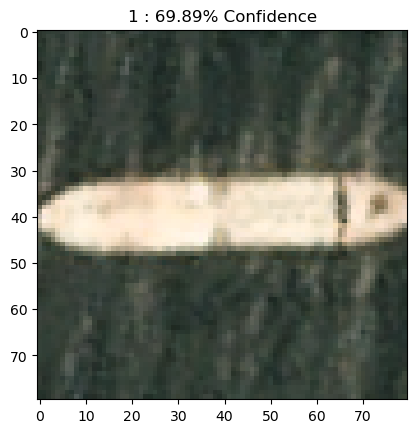

In [90]:
plt.figure()
plt.imshow(examples[5])
confidence = tf.nn.softmax(dp_model(np.reshape(examples[5],[1,80,80,3])).numpy())[0,1]
if confidence < 0.5:
    pred = 0
    confidence = 1. - confidence
else:
    pred = 1
plt.title('{} : {:.2f}% Confidence'.format(str(pred), confidence*100))
plt.show()

In [91]:
dp_model.evaluate(test_dataset.take(-1))

1/1 [==============================] - 0s 33ms/step - loss: 0.9770 - categorical_accuracy: 0.7962 - categorical_crossentropy: 0.9770


[0.9769961833953857, 0.7962499856948853, 0.9769961833953857]